# CB02-3: A Tiny Autograd Framwork for Scalar
Following the idea of MicroGrad by Andrej Karpathy: 
[Micrograd github](https://github.com/karpathy/micrograd);
[Video Lecture](https://www.bilibili.com/video/BV1aB4y13761/?spm_id_from=333.337.search-card.all.click)

## Part One: Recap
coding: Building "An MLP with 2 hidden layers that solves Mnist" with pure Python & Numpy
1. forward pass
2. mini-batch SGD
3. Backward pass: Back Propagation via Manual derivative calculation

Key: update each w & b by $-\eta\nabla C$ (for each mini batch)


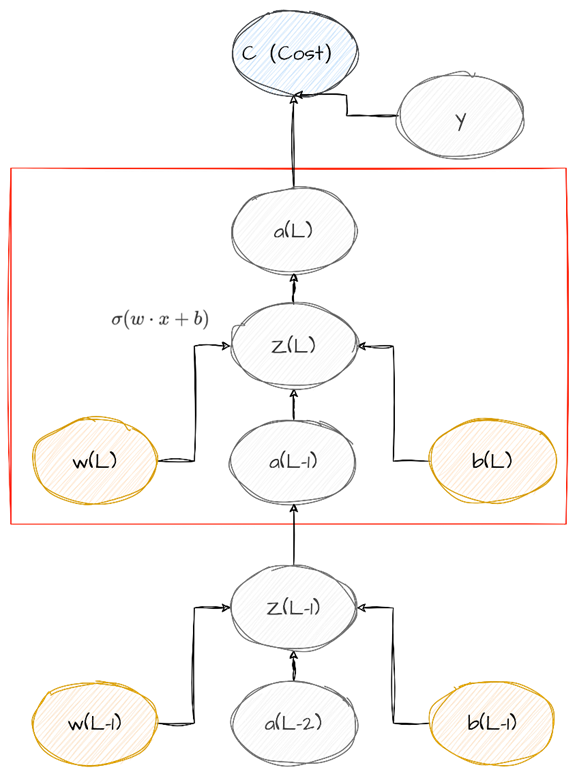
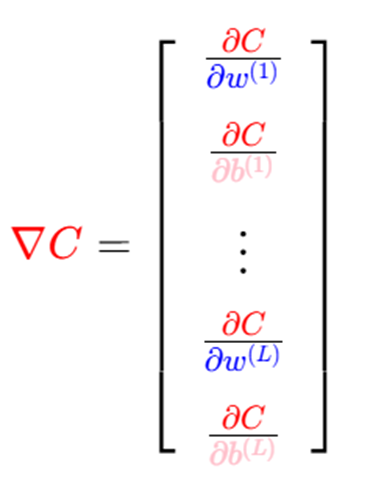

## Part Two: A Tiny Autograd Framework for Scalar

### Step 1: Create Value Class

In [1]:
class Value:
    def __init__(self,data):
        self.data = data

    def __repr__(self) -> str:
        return f'Value(Data={self.data})'
    
    def __add__(self, other):
        return Value(self.data + other.data)
    
    def __mul__(self, other):
        return Value(self.data * other.data)

In [2]:
a = Value(4.0)
b = Value(3.0)
a + b, a * b 
# a.__add__(b), a.__mul__(b)

(Value(Data=7.0), Value(Data=12.0))

### Step 2: Visualizing the Computational Graph
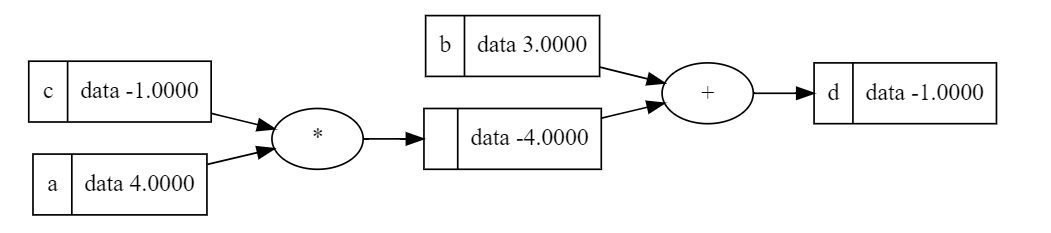

In [3]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._children = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f'Value(Data={self.data})'
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    

In [4]:
a = Value(4); a.label = 'a'
b = Value(3.0); b.label = 'b'
a + b # a.__add__(b)
a * b # a.__mul__(b)
c =  Value(-1.0);c.label = 'c'
d = a * c; d.label = 'd'
e = d + b; d.label = 'd' ;e.label = 'e'# a.__mul__(c).__add__(b)

In [5]:
e._children
for child in e._children:
    print(child.label)
e._op

d
b


'+'

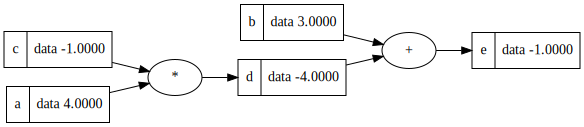

In [6]:
from draw import draw_dot1
draw_dot1(e)

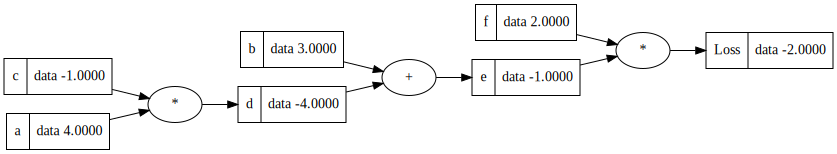

In [7]:
f = Value(2.0); f.label = 'f'
Loss = f * e; Loss.label = 'Loss'
draw_dot1(Loss)

### Sum For Now(S1&S2)
1. Forward Pass for Scalar
2. next, backward pass: Gradient(dl/dw, dl/db)

### Step 3: Calculate Gradients Manually


In [8]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data    
        self._children = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0

    def __repr__(self) -> str:
        return f'Value(Data={self.data})'
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')    
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

In [9]:
a = Value(4); a.label = 'a'
b = Value(3.0); b.label = 'b'
a + b # a.__add__(b)
a * b # a.__mul__(b)
c =  Value(-1.0);c.label = 'c'
d = a * c; d.label = 'd'
e = d + b; d.label = 'd' ;e.label = 'e'# a.__mul__(c).__add__(b)
f = Value(2.0); f.label = 'f'
Loss = f * e; Loss.label = 'Loss'

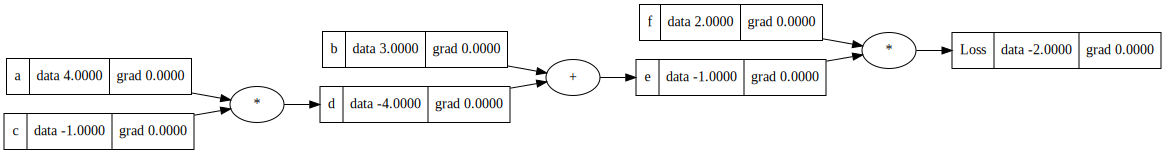

In [10]:
from draw import draw_dot
draw_dot(Loss)

first, 
dl/dl = 1
dl/de = f (L = f * e)
dl/df = e

then,
de/dd = 1 -> dl/dd = dl/de * de/dd = f
de/db = 1 -> dl/db = dl/de * de/db = e

Finally,
dd/dc = a -> dl/dc = dl/dd * dd/dc = f * a
dd/da = c -> dl/da = dl/dd * dd/da = f * c


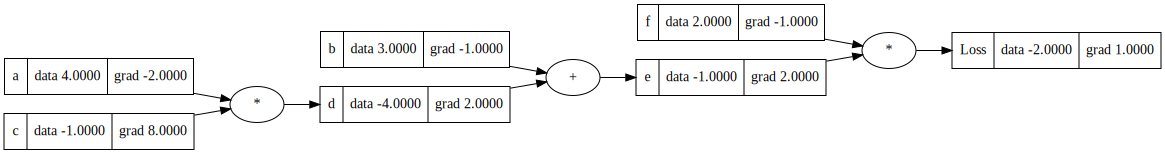

In [11]:
Loss.grad = 1.0
e.grad = 2.0
f.grad = -1.0

d.grad = 2.0
b.grad = -1.0

a.grad = -2.0
c.grad = 8.0
draw_dot(Loss)

Note:

BP update rule: $-\eta\nabla C$

suppose $\eta = 1$, b & e are chanagable

then 
- new_b = b - 1 * (-1.0) = 3.0 + 1.0 
- new_e = e - 1 * (2.0) = -1.0 - 2.0

### Step 4: Activation Functions
So far, only + & * implemented

In [12]:
import numpy as np
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._children = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0

    def __repr__(self) -> str:
        return f'Value(Data={self.data})'
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    # activaiton function
    def sigmoid(self):
        data = 1/(1 + np.exp(-self.data))
        out = Value(data, (self,), 'sigmoid')
        return out
    
    def relu(self):
        data = np.maximum(0, self.data)
        out = Value(data, (self,), 'relu')
        return out
    
    def tanh(self):
        data = np.tanh(self.data)
        out = Value(data, (self,), 'tanh')
        return out

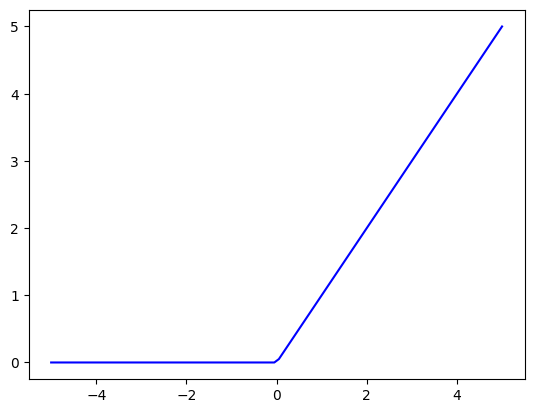

In [13]:
# plot sigmoid, tanh and relu in [-5, 5]
import matplotlib.pyplot as plt
x = np.linspace(-5, 5, 100)
# plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid', color = 'red')
# plt.plot(x, np.tanh(x), label = 'tanh', color = 'yellow')
plt.plot(x, np.maximum(0, x), label = 'relu', color = 'blue')

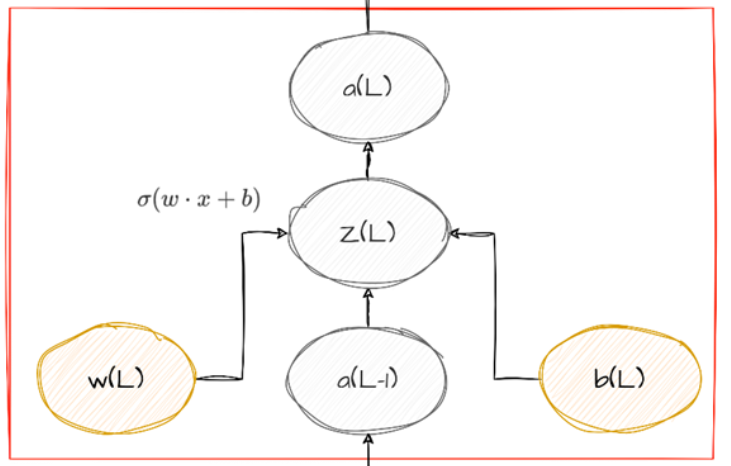

### Step 5: Backward/Derivative for Single Operation

In [14]:
import numpy as np
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._children = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f'Value(Data={self.data})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    # activaiton function
    def sigmoid(self):
        data = 1/(1 + np.exp(-self.data))
        out = Value(data, (self,), 'sigmoid')
        def _backward():
            self.grad = out.data * (1 - out.data) * out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        data = np.maximum(0, self.data)
        out = Value(data, (self,), 'relu')
        def _backward():
            self.grad = (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        data = np.tanh(self.data)
        out = Value(data, (self,), 'tanh')

        def _backward():
            self.grad = (1 - out.data**2) * out.grad
        out._backward = _backward

        return out

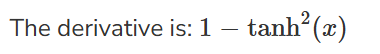
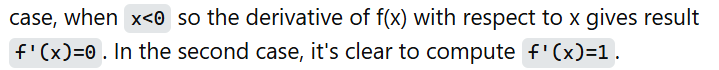
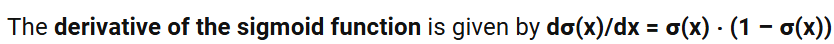

In [15]:
# inputs x1 & x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biase
b = Value(6.7, label='b')

# linear combination
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2+b; n.label = 'n'
o = n.sigmoid(); o.label = 'o'

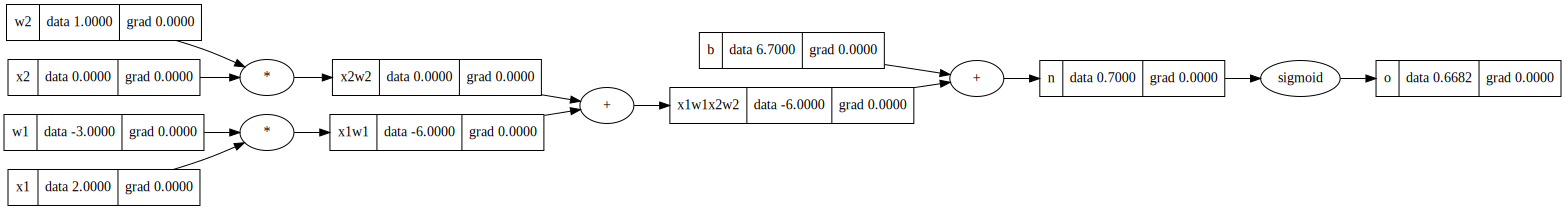

In [16]:
from draw import draw_dot
draw_dot(o)

In [17]:
o.grad = 1.0
o._backward()

n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

x1._backward()
w1._backward()
x2._backward()
w2._backward()

In [18]:
x1.grad, w1.grad, x2.grad, w2.grad, b.grad

(np.float64(-0.6651386198793271),
 np.float64(0.4434257465862181),
 np.float64(0.22171287329310904),
 np.float64(0.0),
 np.float64(0.22171287329310904))

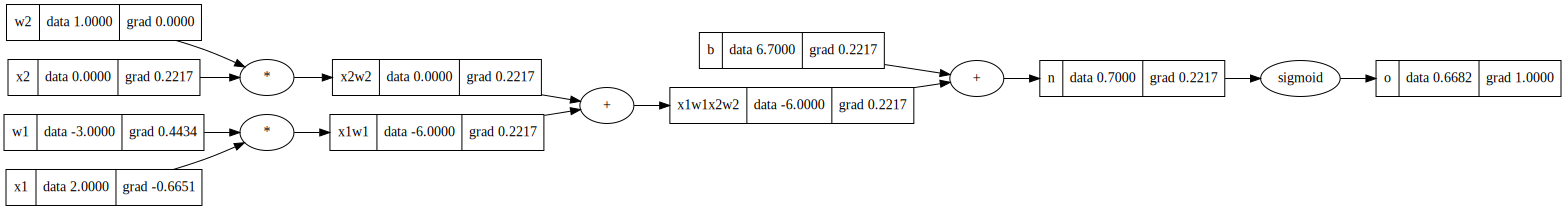

In [19]:
draw_dot(o)

### Step 6: BP through all nodes

In [20]:
# topological sort
topo = []
labels = []
visited = set()

def topo_sort(root):
    if root not in visited:
        visited.add(root)
        for child in root._children:
            topo_sort(child)
        topo.append(root)
        labels.append(root.label)

topo_sort(o)
topo, labels

([Value(Data=2.0),
  Value(Data=-3.0),
  Value(Data=-6.0),
  Value(Data=1.0),
  Value(Data=0.0),
  Value(Data=0.0),
  Value(Data=-6.0),
  Value(Data=6.7),
  Value(Data=0.7000000000000002),
  Value(Data=0.6681877721681662)],
 ['x1', 'w1', 'x1w1', 'w2', 'x2', 'x2w2', 'x1w1x2w2', 'b', 'n', 'o'])

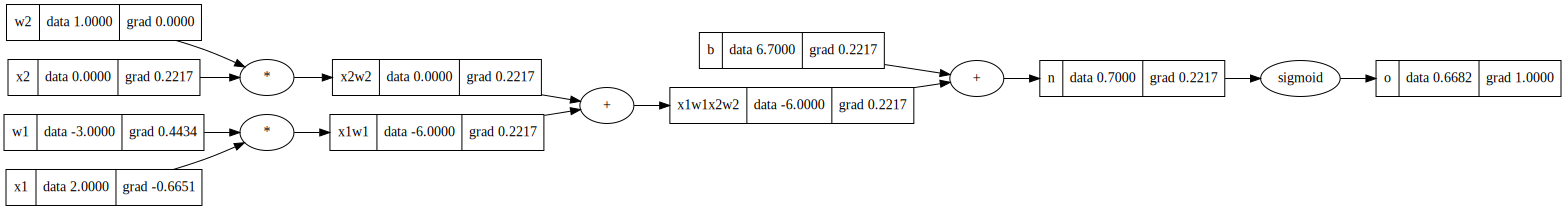

In [21]:
o.grad = 1.0
for node in reversed(topo):
    node._backward()
draw_dot(o)

In [22]:
import numpy as np
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._children = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f'Value(Data={self.data})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    # activaiton function
    def sigmoid(self):
        data = 1/(1 + np.exp(-self.data))
        out = Value(data, (self,), 'sigmoid')
        def _backward():
            self.grad = out.data * (1 - out.data) * out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        data = np.maximum(0, self.data)
        out = Value(data, (self,), 'relu')
        def _backward():
            self.grad = (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        data = np.tanh(self.data)
        out = Value(data, (self,), 'tanh')

        def _backward():
            self.grad = (1 - out.data**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def topo_sort(node):
            if node not in visited:
                visited.add(node)
                for child in node._children:
                    topo_sort(child)
                topo.append(node)

        topo_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [23]:
# inputs x1 & x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biase
b = Value(6.7, label='b')

# linear combination
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2+b; n.label = 'n'
o = n.sigmoid(); o.label = 'o'

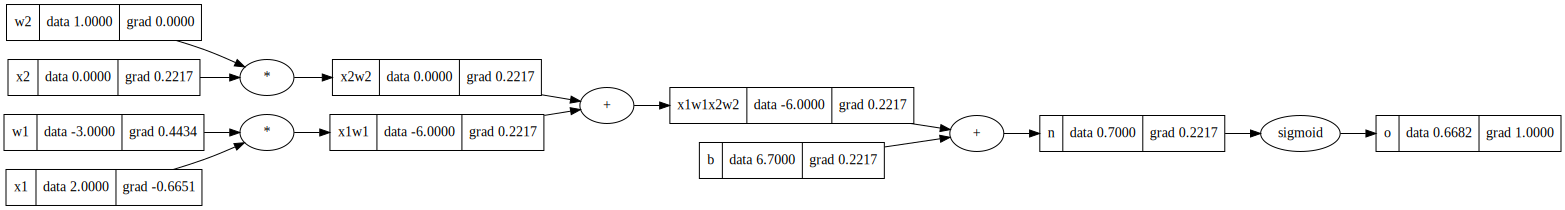

In [24]:
o.backward()
draw_dot(o)

### Step 7: Solving a few bugs

1.0


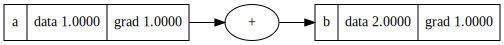

In [25]:
a = Value(1.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
print(a.grad)
draw_dot(b)

In [26]:
a + 1, a * 1

AttributeError: 'int' object has no attribute 'data'

In [27]:
1 + a, 1 * a

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [34]:
import numpy as np
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data    
        self._children = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f'Value(Data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')   
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out 
    
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    # Activations
    def sigmoid(self):
        data = 1/(1 + np.exp(-self.data))
        out = Value(data, (self,), 'sigmoid')

        def _backward():
            self.grad += out.data * (1 - out.data) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        data = np.tanh(self.data)
        out = Value(data, (self,), 'tanh')
        def _backward(self):
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        data = np.maximum(0, self.data)
        out = Value(data, (self,), 'relu')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def topo_sort(node):
            if node not in visited:
                visited.add(node)
                for child in node._children:
                    topo_sort(child)
                topo.append(node)

        topo_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

2.0


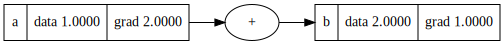

In [35]:
a = Value(1.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
print(a.grad)
draw_dot(b)

In [36]:
a + 1, a * 1 

(Value(Data=2.0), Value(Data=1.0))

In [37]:
1 + a, 1 * a # 1.__add__(a), 1.__mul__(a)

(Value(Data=2.0), Value(Data=1.0))

### Step 8: Rethinking what operations have been created
1. +, *
2. activations: sigmoid, tanh, relu

TODOs:
1. \-
2. /
3. power(a**n)

Customized functions.

In [38]:
import numpy as np
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data    
        self._children = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f'Value(Data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')   
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out 
    
    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)) # 'only support int or float'
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        
        return out

    def __truediv__(self, other):
        return self * other ** -1
    

    def __rtruediv__(self, other):
        return other * self ** -1

    # Activations
    def sigmoid(self):
        data = 1/(1 + np.exp(-self.data))
        out = Value(data, (self,), 'sigmoid')

        def _backward():
            self.grad += out.data * (1 - out.data) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        data = np.tanh(self.data)
        out = Value(data, (self,), 'tanh')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        return out
        # data = np.tanh(self.data)
        # out = Value(data, (self,), 'tanh')
        # def _backward(self):
        #     self.grad += (1 - out.data**2) * out.grad
        # out._backward = _backward
        # return out
    
    def relu(self):
        data = np.maximum(0, self.data)
        out = Value(data, (self,), 'relu')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def topo_sort(node):
            if node not in visited:
                visited.add(node)
                for child in node._children:
                    topo_sort(child)
                topo.append(node)

        topo_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [39]:
a =  Value(2.0, label='a')
b = Value(4.0, label='b')
a/b, a-b, a-1, 1-a, b/2, 2/b

(Value(Data=0.5),
 Value(Data=-2.0),
 Value(Data=1.0),
 Value(Data=-1.0),
 Value(Data=2.0),
 Value(Data=0.5))

In [40]:
a ** 2

Value(Data=4.0)

### Summary

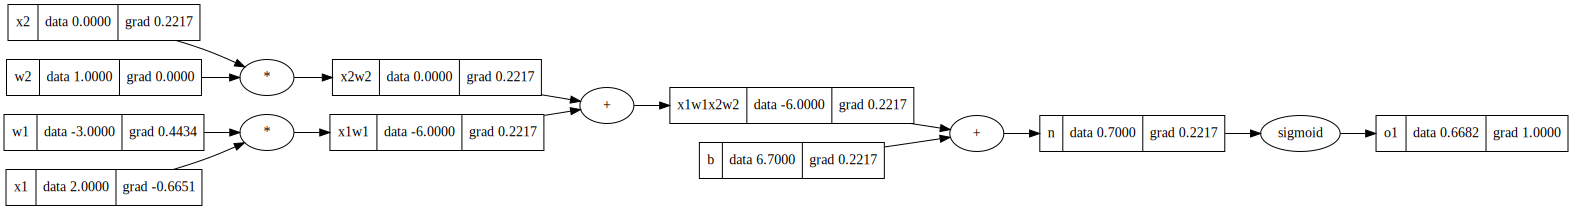

In [41]:
# inputs x1 & x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biase
b = Value(6.7, label='b')

# linear combination
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2+b; n.label = 'n'
o1 = n.sigmoid(); o1.label = 'o1'
o1.backward()
draw_dot(o1)

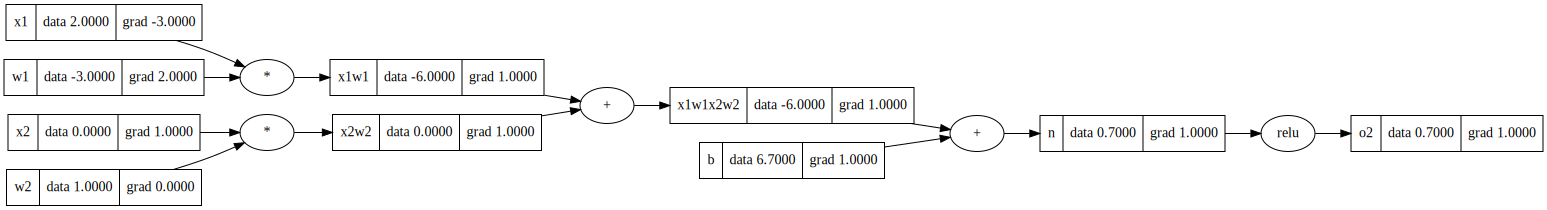

In [42]:
# inputs x1 & x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biase
b = Value(6.7, label='b')

# linear combination
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2+b; n.label = 'n'
o2 = n.relu(); o2.label = 'o2'
o2.backward()
draw_dot(o2)

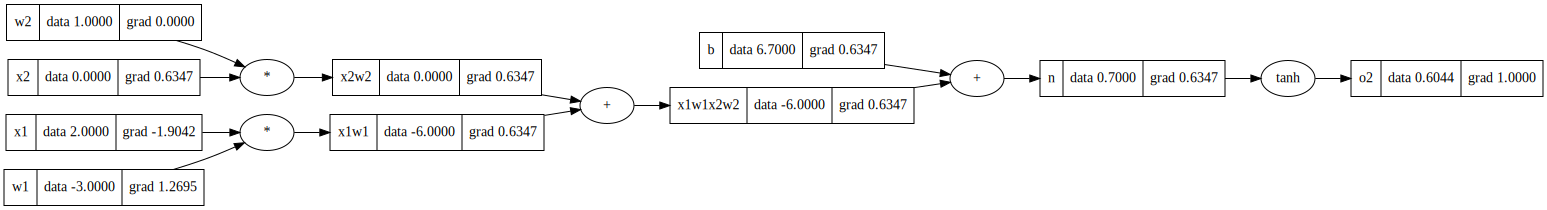

In [39]:
# inputs x1 & x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# biase
b = Value(6.7, label='b')

# linear combination
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2+b; n.label = 'n'
o2 = n.tanh(); o2.label = 'o2'
o2.backward()
draw_dot(o2)

## Part Three: Pytorch Implementation

In [1]:
import torch 
x1 = torch.Tensor([2.0]); x1.requires_grad=True
x2 = torch.Tensor([0.0]); x2.requires_grad=True
w1 = torch.Tensor([-3.0]); w1.requires_grad=True
w2 = torch.Tensor([1.0]); w2.requires_grad=True
b = torch.Tensor([6.7]); b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.sigmoid(n)
print('result is :', o.data.item())
o.backward()
x1.grad, x2.grad, w1.grad, w2.grad, b.grad

result is : 0.6681877374649048


(tensor([-0.6651]),
 tensor([0.2217]),
 tensor([0.4434]),
 tensor([0.]),
 tensor([0.2217]))

In [2]:
x1 = torch.Tensor([2.0]); x1.requires_grad=True
x2 = torch.Tensor([0.0]); x2.requires_grad=True
w1 = torch.Tensor([-3.0]); w1.requires_grad=True
w2 = torch.Tensor([1.0]); w2.requires_grad=True
b = torch.Tensor([6.7]); b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print('result is :', o.data.item())
o.backward()
x1.grad, x2.grad, w1.grad, w2.grad, b.grad

result is : 0.6043676733970642


(tensor([-1.9042]),
 tensor([0.6347]),
 tensor([1.2695]),
 tensor([0.]),
 tensor([0.6347]))

In [3]:
x1 = torch.Tensor([2.0]); x1.requires_grad=True
x2 = torch.Tensor([0.0]); x2.requires_grad=True
w1 = torch.Tensor([-3.0]); w1.requires_grad=True
w2 = torch.Tensor([1.0]); w2.requires_grad=True
b = torch.Tensor([6.7]); b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.relu(n)
print('result is :', o.data.item())
o.backward()
x1.grad, x2.grad, w1.grad, w2.grad, b.grad

result is : 0.6999998092651367


(tensor([-3.]), tensor([1.]), tensor([2.]), tensor([0.]), tensor([1.]))

## Next Video - CB02-4
Introduction 2 PyTorch
- Tensor
- AutoGrad Engine
- nn.module(DL Library)